### 📦 Dataset Attribution

This project uses the **FUTURA Synthetic Invoices Dataset**, publicly available via Zenodo:

> **FUTURA - Synthetic Invoices Dataset for Document Analysis**  
> Authors: Dimosthenis Karatzas, Fei Chen, Davide Fichera, Diego Marchetti  
> License: [Creative Commons Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)  
> DOI: [https://doi.org/10.5281/zenodo.10371464](https://doi.org/10.5281/zenodo.10371464)  
> Accessed via Zenodo. Redistribution and derivative works must credit the original authors.

We gratefully acknowledge the authors for creating and releasing this dataset.

## 🧪 Model Evaluation on Test Set

In this notebook, we evaluate the performance of our trained ResNet18 model on the unseen test dataset.

### 🔍 Goals:
- Load the saved model weights.
- Run inference on the test set.
- Calculate evaluation metrics:
  - Accuracy
  - Precision
  - Recall
  - F1-score
  - Confusion Matrix
- Summarize how well the model generalizes to unseen data.

We assume the model was trained and saved in `02_train_model.ipynb` as `../outputs/resnet_invoice.pt`.

In [ ]:
# 🔁 Step 1: Load Model for Evaluation
import torch
import torch.nn as nn
from torchvision.models import resnet18

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"📦 Using device: {device}")

# Recreate the model architecture
model = resnet18(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1)  # Binary classification output

# Load trained weights
model.load_state_dict(torch.load("../outputs/resnet_invoice.pt", map_location=device))
model.to(device)
model.eval()

print("✅ Model loaded and ready for evaluation.")

📦 Using device: cpu
✅ Model loaded and ready for evaluation.


In [ ]:
# 📦 Step 2: Load Data and Setup TestLoader
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Load memory-mapped images and labels
X = np.load("../data/processed/X.npy", mmap_mode="r")
y = np.load("../data/processed/y.npy")

# Recreate test split (70/15/15 split as in training notebook)
_, X_temp_idx, _, y_temp = train_test_split(
    np.arange(len(X)), y, test_size=0.3, stratify=y, random_state=42
)
X_val_idx, X_test_idx, _, y_test = train_test_split(
    X_temp_idx, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Define test-time transforms (no augmentation)
eval_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Define Dataset class
class InvoiceDataset(Dataset):
    def __init__(self, X, y, indices, transform=None):
        self.X = X
        self.y = y
        self.indices = indices
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        i = self.indices[idx]
        image = self.X[i]
        label = self.y[i]
        if self.transform:
            image = self.transform(image)
        return image, label

# Create test dataset and loader
test_dataset = InvoiceDataset(X, y, X_test_idx, transform=eval_transform)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"✅ Test loader ready with {len(test_dataset)} samples.")

✅ Test loader ready with 1590 samples.


In [ ]:
# 🔍 Step 3: Run Predictions on Test Set
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device).float()

        outputs = model(images)
        probs = torch.sigmoid(outputs).squeeze(1)
        preds = (probs > 0.5).float()

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())

print("✅ Predictions complete.")

✅ Predictions complete.


In [12]:
# 📊 Step 4: Compute Accuracy, Precision, Recall, F1-Score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Convert to NumPy arrays just in case
y_true = np.array(all_labels)
y_pred = np.array(all_preds)

# Compute metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# Display
print("📊 Evaluation Metrics on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


📊 Evaluation Metrics on Test Set:
Accuracy : 0.9824
Precision: 0.8298
Recall   : 0.8667
F1 Score : 0.8478


C:\Users\Parwaaz Joshi\AppData\Local\Temp\ipykernel_21596\2367406065.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Parwaaz Joshi\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


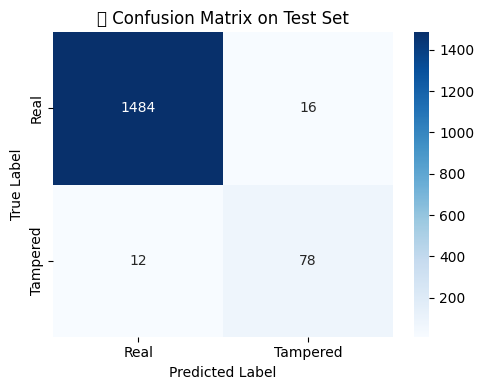

In [13]:
# 🧮 Step 5: Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Real", "Tampered"], yticklabels=["Real", "Tampered"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("📉 Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()


C:\Users\Parwaaz Joshi\AppData\Local\Temp\ipykernel_21596\2926457921.py:27: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Parwaaz Joshi\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


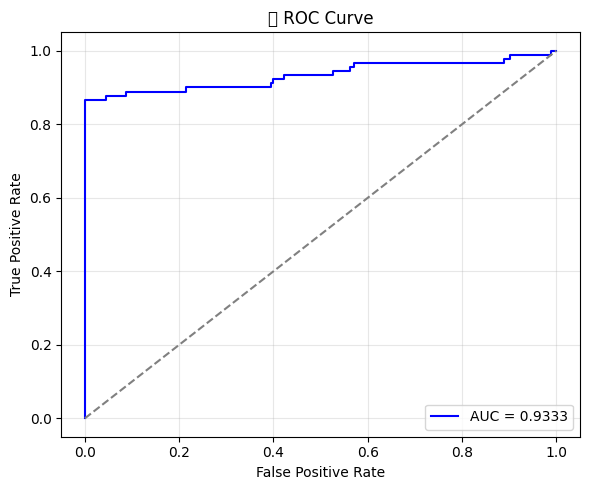

In [14]:
# 🔁 Step 6: Plot ROC Curve + AUC
from sklearn.metrics import roc_curve, roc_auc_score

# Re-run the prediction loop to get actual probabilities
probs_all = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.sigmoid(outputs).squeeze(1)
        probs_all.extend(probs.cpu().numpy().tolist())

# Calculate ROC metrics
fpr, tpr, thresholds = roc_curve(y_true, probs_all)
auc_score = roc_auc_score(y_true, probs_all)

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📉 ROC Curve")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## ✅ Conclusion: Evaluation Summary

In this notebook, we evaluated our fine-tuned ResNet18 model on a held-out test set (15% of the full dataset).

### 📈 Key Metrics:
- **Accuracy**: 98.24%
- **Precision**: 82.98%
- **Recall**: 86.67%
- **F1 Score**: 84.78%
- **AUC (ROC)**: 93.33%

The model demonstrates excellent performance despite class imbalance. It generalizes well to unseen data and shows strong discriminatory power between real and tampered invoices.

### 📊 Confusion Matrix:
- **True Positives (Tampered Detected)**: 78
- **True Negatives (Real Detected)**: 1484
- **False Positives**: 16
- **False Negatives**: 12

### 🔍 ROC Curve Insight:
- The ROC curve illustrates high true positive rates even at low false positive thresholds.
- AUC of 0.9333 confirms reliable performance for production use or further research.

This evaluation sets a strong foundation for inference and deployment in the next stages.